# This notebook shows how to solve a majority judgment

# 1. Basic functions

In [2]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('../')

import django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "jmapp.settings")
django.setup()

from majority_judgment.tools import *

class Result():
    """ Store a candidate with one's ratings """
    def __init__(self, name, ratings, grades):
        self.name      = name
        self.ratings   = ratings
        self.grades    = grades
        self.scores    = sorted_scores(ratings, len(grades))
        #print(judgments)

    def __lt__(self, other):
        return tie_breaking(self.ratings, other.ratings)

    def __repr__(self):
        return str(self.name)

    def __str__(self):
        return str(self.name)

# 2. Generate data

In [2]:
# parameters    
Nratings     = 300
grades       = ["Excellent", "Good", "Fair", "Poor", "Reject"]
Ngrades      = len(grades)
candidates   = ["Bayrou", "Royal", "Sarkozy", "Voynet", "Besancenot", \
                "Buffet", "Bové", "Laguiller", "Nihous", "de Villiers", \
                "Schivardi", "Le Pen"]
Ncandidates  = len(candidates)

# generate data
results   = []
scores    = np.zeros((Ncandidates, Ngrades))

for i in range(Ncandidates):
    ratings = np.random.randint(0, Ngrades, Nratings)
    r       = Result(candidates[i], ratings, grades)
    results.append(r)
    scores[i, :] = sorted_scores(ratings, Ngrades)

# 3. Visualize the sorted scores

<IPython.core.display.Javascript object>


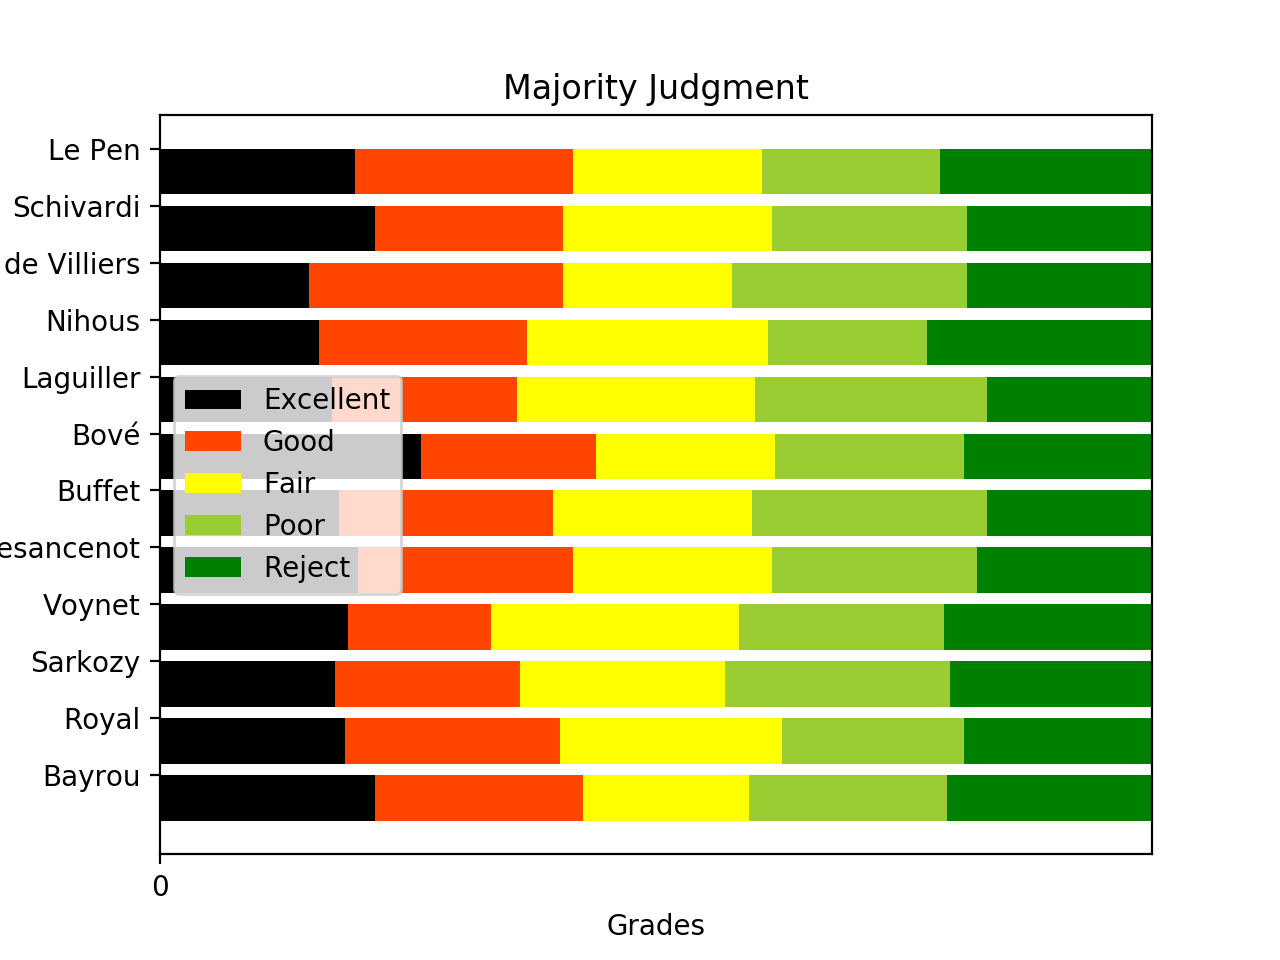

In [3]:
# colors from mieux choisir
colors = ['#5555AA', '#5E84C2', '#008080', '#ED5960', '#BB0000']
# colors from matplotlib
colors = [plt.cm.plasma(1-k/Ngrades, 1) for k in range(Ngrades)]
# colors from wikipedia majority judgment
colors = [ "black", "orangered", "yellow", "YellowGreen", "green"] 


plot_scores(scores, grades, names=candidates, height = 0.8, color = colors)
plt.show()

# 4. Final results

In [4]:
res = majority_judgment(results)
print("Ranking is: " + ", ".join(map(str, res)))

Ranking is: Laguiller, Besancenot, Schivardi, Voynet, Sarkozy, de Villiers, Royal, Bayrou, Bové, Le Pen, Nihous, Buffet


# 5. With the Django database


<IPython.core.display.Javascript object>


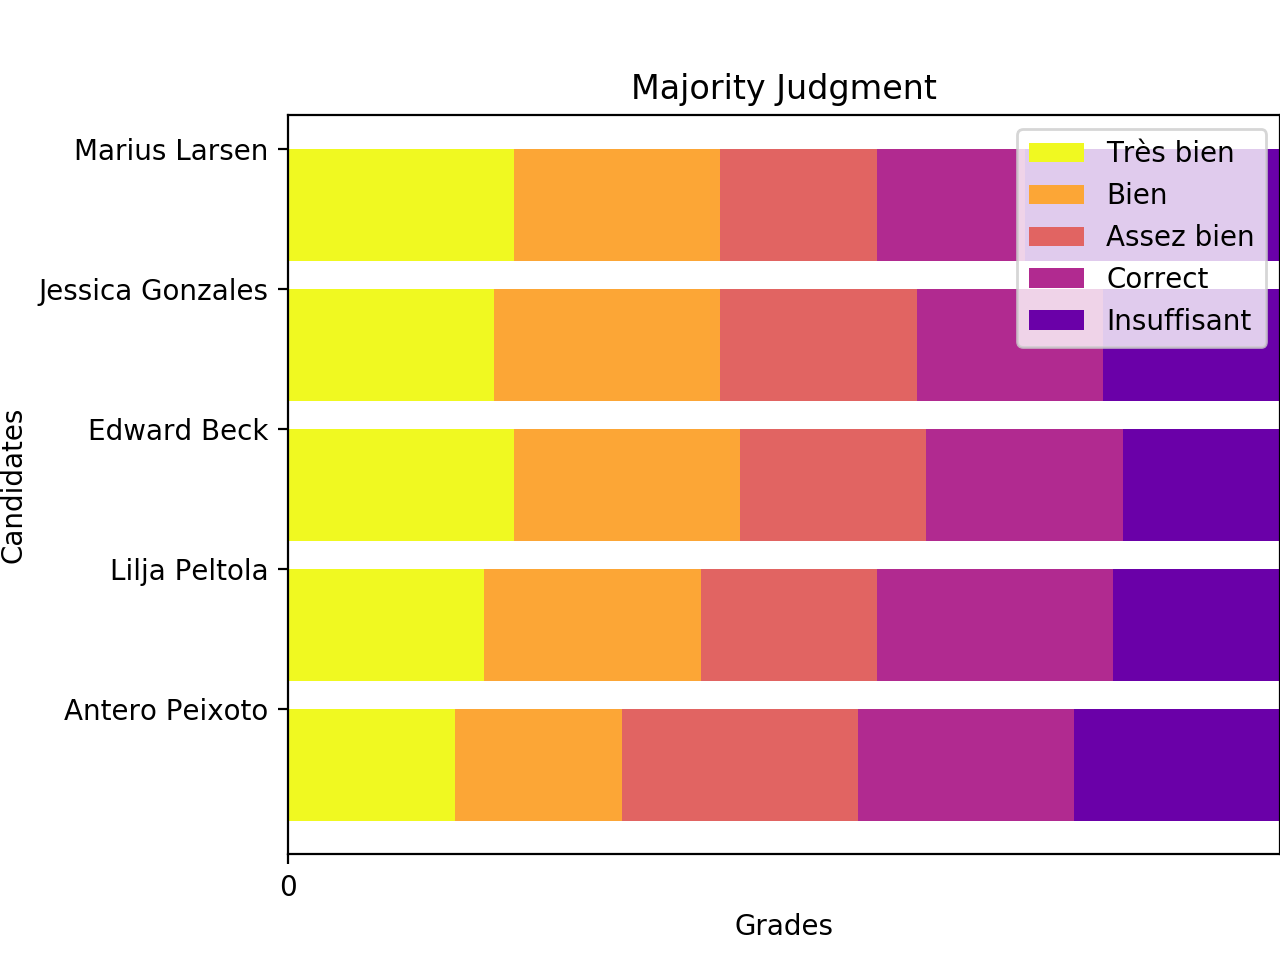

In [48]:
# read database
grades  = [g.name for g in Grade.objects.all()]
scores  = get_scores()
names   = []
for c in Candidate.objects.all():
    name = c.user.first_name.title() + " " + c.user.last_name.title()
    names.append(name)

# display figure
fig = plt.figure()
ax = fig.add_subplot(111)
plot_scores(scores, grades=grades,  names=names, figure=fig)
pos1 = ax.get_position() # get the original position 
pos2 = [pos1.x0 + 0.1, pos1.y0,  pos1.width, pos1.height] 
ax.set_position(pos2) 
plt.show()

In [10]:
ratings = Rating.objects.filter(candidate=Candidate.objects.first())    \
                                .values('grade')            \
                                .annotate(dcount=Count('grade'))

In [21]:
def get_scores():
    """ Compute a 2D array with all the ratings from the candidates
    FIXME: select only candidates from an election
    """

    grades     = Grade.objects.all()
    candidates = Candidate.objects.all()
    scores     = np.zeros( (len(candidates), len(grades)) )

    for i in range(len(candidates)):
        ratings   = Rating.objects.filter(candidate=candidates[i])
        Nratings  = len(ratings)   
        rates     = ratings.values('grade').annotate(dcount=Count('grade'))
        scores[i] = [r['dcount'] for r in rates]
        scores[i]/= Nratings

    return scores

print(get_scores())

[[ 0.16831683  0.16831683  0.23762376  0.21782178  0.20792079]
 [ 0.1980198   0.21782178  0.17821782  0.23762376  0.16831683]
 [ 0.22772277  0.22772277  0.18811881  0.1980198   0.15841584]
 [ 0.20792079  0.22772277  0.1980198   0.18811881  0.17821782]
 [ 0.22772277  0.20792079  0.15841584  0.14851485  0.25742574]]
